In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math
from tqdm import tqdm
import seaborn as sns
from IPython.display import display, Markdown
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import geopandas as gpd
import pandas as pd
import matplotlib.colors as mcolors
import imageio.v2 as imageio
import os
import tempfile
from PIL import Image, ImageDraw, ImageFont
from IPython.display import HTML
from scipy.optimize import minimize
from scipy.integrate import odeint

In [2]:
with open("London_Patch_Populations_3km_fixed.pkl", "rb") as file:
    pop_dict = pickle.load(file)
pop_array = np.array(list(pop_dict.values()))
pop_array.shape

(251,)

In [49]:
# Load files
with open("London Condensed P Matrix.pkl", "rb") as file:
    sparse_p = pickle.load(file)

p_matrix = sparse_p.toarray()

# with open("London Condensed Population Vector.pkl", "rb") as file:
    # pop_vector = pickle.load(file)
    
with open("London_Patch_Populations_3km_fixed.pkl", "rb") as file:
    pop_dict = pickle.load(file)

small_pop_vector = np.array(list(pop_dict.values()))
pop_vector = np.zeros(63001)  # Create a zero array of the desired size

# Assign values at the correct positions
pop_vector[np.arange(251) * (251 + 1)] = small_pop_vector


with open("London Borough List.pkl", 'rb') as f:
    borough_list = pickle.load(f)
    
with open("London Station List.pkl", "rb") as file:
    station_list = pickle.load(file)
    
with open("London Subpopulation List.pkl", 'rb') as f:
    subpop_list = pickle.load(f)
    
with open("London Completed Commuter Matrix.pkl", "rb") as file:
    completed_commuter_matrix = pickle.load(file)

with open("London Home Patch Indices.pkl", "rb") as file:
    home_patches = pickle.load(file)
    
with open("London Travel Patch Indices.pkl", "rb") as file:
    travel_patches = pickle.load(file)

with open("London Travel Patch Names.pkl", "rb") as file:
    travel_patch_names = pickle.load(file)
    
with open("London new Nj.pkl", "rb") as file:
    Nj = pickle.load(file)

with open("London N=0 Indices Set.pkl", "rb") as file:
    N_0_set = pickle.load(file)

with open("London Station Borough List.pkl", 'rb') as f:
    station_borough_list = pickle.load(f)

with open("London Unique Patches.pkl", 'rb') as f:
    valid_patches = pickle.load(f)
    
with open("London Valid Patch Indices.pkl", 'rb') as f:
    valid_patch_indices = pickle.load(f)

with open("London Nonempty Subpopulation Indices.pkl", 'rb') as f:
    nonempty_subpop_indices = pickle.load(f)

with open("London Travel Patch Names.pkl", "rb") as file:
    travel_patch_names = pickle.load(file)

with open("final_best_beta_with_R.pkl", "rb") as file:
    betas = pickle.load(file)
    
covid_df = pd.read_csv("phe_cases_london_boroughs_fixed.csv")

borough_populations = pd.read_csv("london population 1801 to 2021_cleaned.csv")

london_gdf = gpd.read_file("Complete London Shapefile.gpkg", layer="Combined_London_Data")



In [7]:
# Define helper functions

# Define plotting function
def plot_indices(array1, array2, indices, names_list, title, params):
    S0,I0,transit_multiplier,baseline_beta,gamma,timesteps = params
    
    x = range(timesteps + 1)  # The x-axis values (0, 1, 2, ...)
    num_plots = len(indices)
    grid_rows = int(np.ceil(np.sqrt(num_plots)))  # Number of rows for the grid
    grid_cols = int(np.ceil(num_plots / grid_rows))  # Number of columns for the grid

    # Create a figure and axes for the grid layout
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(12, 8))
    axes = axes.flatten()  # Flatten in case of a 2D grid for easier indexing

    for i, idx in enumerate(indices):
        ax = axes[i]
        ax.plot(x, array1[idx], label='S')
        ax.plot(x, array2[idx], label='I')
        ax.set_xlabel('Timesteps')
        ax.set_ylabel('Values')
        ax.set_title(f'{names_list[idx]}')
        ax.legend()
        ax.grid(True)  # Optional: Add grid lines for better readability
        ax.set_ylim(0, 1)  # Set y-axis limits between 0 and 1

    # Hide any unused subplots
    for ax in axes[num_plots:]:
        ax.set_visible(False)

    # Set the overall title for the figure
    fig.suptitle(title, fontsize=16, weight='bold')

    # Adjust layout for better spacing, considering the suptitle
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
# Function to plot 'I' indices for all regions with only top 5 and bottom 5 in legend
def plot_comparison(array2, names_list, title):
    x = range(len(array2[0]))  # Assuming array2 has shape (regions, timesteps)
    
    # Calculate final values and sort by descending order
    final_values = array2[:, -1]
    sorted_indices = np.argsort(final_values)[::-1]  # Indices sorted by descending final values
    
    plt.figure(figsize=(12, 8))
    for idx in sorted_indices:  # Plot in sorted order
        plt.plot(x, array2[idx], alpha=0.4)  # Reduced alpha for clarity in background
    
    # Select top 5 and bottom 5 for legend
    top_5_indices = sorted_indices[:5]
    bottom_5_indices = sorted_indices[-5:]
    legend_indices = np.concatenate([top_5_indices, bottom_5_indices])
    
    for idx in legend_indices:
        plt.plot(x, array2[idx], label=f'I - {names_list[idx]} ({final_values[idx]:.4f})')
    
    plt.xlabel('Timesteps')
    plt.ylabel('Values')
    plt.title(title, fontsize=16, weight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Optional: Adjust legend outside plot
    plt.grid(True)
    plt.show()
    
    # Find and print extremes
    print(f"Top 5 highest end states:")
    for idx in top_5_indices:
        print(f"{names_list[idx]}: {final_values[idx]:.4f}")
    
    print(f"\nBottom 5 lowest end states:")
    for idx in bottom_5_indices:
        print(f"{names_list[idx]}: {final_values[idx]:.4f}")


# Function to plot extreme indices with only top 5 and bottom 5 in legend
def plot_comparison_extremes(array2, labels, top_n, mode="short", group="all", title="Subpopulations Comparison"):
    """
    Plots a continuous spectrum of color between the topmost and bottommost lines
    while calculating and printing the top/bottom entries.

    Parameters:
        array2 (ndarray): A 2D array of shape (regions, timesteps).
        labels (list): A list of labels corresponding to the regions.
        top_n (int): Number of top/bottom entries to calculate and print.
        mode (str): One of ["short", "long", "top", "bottom"] (currently unused for this gradient plot).
        group (str): One of ["all", "homebodies", "travellers"] (currently unused for this gradient plot).
        title (str): Title of the plot.
    """

    x = np.arange(array2.shape[1])  # Time steps

    # Exclude rows with all zeros
    nonzero_indices = np.any(array2 > 0, axis=1)
    filtered_array2 = array2[nonzero_indices]
    filtered_labels = np.array(labels)[nonzero_indices]

    # Calculate final values
    final_values = filtered_array2[:, -1]

    # Sort indices by descending order of final values
    sorted_indices = np.argsort(final_values)[::-1]

    # Get top and bottom indices
    top_indices = sorted_indices[:top_n]
    bottom_indices = sorted_indices[-top_n:]

    # Compute max and min at each timestep
    y_min = np.min(filtered_array2, axis=0)
    y_max = np.max(filtered_array2, axis=0)

    # Define the number of bins
    total_lines = len(final_values)
    n_bins = int(np.round(math.log(total_lines,10)*10,1))

    # Create figure
    plt.figure(figsize=(12, 8))
    cmap = plt.cm.coolwarm  # Blue for low density, red for high density
    norm = Normalize(vmin=0, vmax=1)

    # Loop through each timestep and calculate densities
    for t in range(len(x) - 1):
        # Define the bins for this timestep and the next
        bins_t = np.linspace(y_min[t], y_max[t], n_bins + 1)
        bins_next = np.linspace(y_min[t + 1], y_max[t + 1], n_bins + 1)

        # Count the number of curves in each bin
        densities_t, _ = np.histogram(filtered_array2[:, t], bins=bins_t)
        densities_next, _ = np.histogram(filtered_array2[:, t + 1], bins=bins_next)

        # Normalize densities for color mapping
        normalized_densities_t = densities_t / densities_t.max() if densities_t.max() > 0 else densities_t
        normalized_densities_next = densities_next / densities_next.max() if densities_next.max() > 0 else densities_next

        # Plot the slanted rectangles between timesteps
        for b in range(n_bins):
            epsilon = 1e-6  # Small overlap factor
            plt.fill(
                [x[t], x[t + 1], x[t + 1], x[t]],
                [
                    bins_t[b] - epsilon,
                    bins_next[b] - epsilon,
                    bins_next[b + 1] + epsilon,
                    bins_t[b + 1] + epsilon,
                ],
                color=cmap(norm((normalized_densities_t[b] + normalized_densities_next[b]) / 2)),
                edgecolor="none",  # Removes any borders
                alpha=1.0,
                antialiased=False,  # Prevents aliasing effects
            )

    # Plot max, min, and mean lines
    mean_values = np.mean(filtered_array2, axis=0)
    plt.plot(x, y_min, color="black", linestyle="-", linewidth=1.5, label="Min")
    plt.plot(x, y_max, color="black", linestyle="-", linewidth=1.5, label="Max")
    plt.plot(x, mean_values, color="black", linestyle="--", linewidth=1.5, label="Mean")

    # Add a colorbar to indicate density
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Enhance aesthetics
    plt.xlabel("Timesteps")
    plt.ylabel("Values")
    plt.title(title, fontsize=16, weight="bold")
    plt.grid(False)
    plt.legend()
    plt.ylim([0,np.max(y_max)*1.1])
    plt.tight_layout()
    plt.show()

    # Print top and bottom details
    print(f"Top {top_n} highest final values:")
    for idx in top_indices:
        print(f"{filtered_labels[idx]}: {final_values[idx]:.4f}")

    print(f"\nBottom {top_n} lowest final values:")
    for idx in bottom_indices:
        print(f"{filtered_labels[idx]}: {final_values[idx]:.4f}")

# Function to plot the distribution of steady states excluding zeros
def plot_distribution(array2, names_list, type):
    final_values = array2[:, -1]  # Get the last timestep values
    nonzero_final_values = final_values[final_values > 0]  # Exclude zero values
    
    if len(nonzero_final_values) == 0:
        print("All final values are zero. No distribution to plot.")
        return
    
    plt.figure(figsize=(10, 6))
    sns.histplot(nonzero_final_values, kde=True, bins=20, color='blue', edgecolor='black', alpha=0.7)
    
    plt.xlabel('Final Proportion Infectious')
    plt.ylabel('Frequency')
    plt.title(rf'Distribution of $\mathbf{{I^*}}$, {type}s', fontsize=16, weight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid for the y-axis
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    display(Markdown(f"**Mean** $I^*$: {np.mean(nonzero_final_values):.4f}"))
    display(Markdown(f"**Median** $I^*$: {np.median(nonzero_final_values):.4f}"))
    display(Markdown(f"**Standard deviation**: {np.std(nonzero_final_values):.4f}"))

# Define index/name conversion functions
def borough_name_to_idx(name):
    return borough_list.index(name)

def station_name_to_idx(name):
    return station_list.index(name)

def subpop_name_to_idx(name):
    return subpop_list.index(name)

# Define functions for isolating initial I population to one borough
def get_stations_from_borough(borough):
    output = []
    for i in range(251):
        if station_borough_list[i]==borough:
            output.append(station_list[i])
    return output

def get_subpop_idx_from_station(station):
    output = []
    for i in range(63001):
        if subpop_list[i][0] == station:
            output.append(i)
    return output

def isolate_borough(borough):
    output = np.zeros(63001)
    idx_list = []
    stations = get_stations_from_borough(borough)
    for station in stations:
        idx_list.append(get_subpop_idx_from_station(station))
    idx_list = np.array(idx_list).flatten().tolist()
    output[idx_list] = 1
    return output

def prepare_solution_for_mapping(solution,params):
    actual_solution = solution[0]
    infection_log = solution[1]
    reshaped_log = np.transpose(infection_log, axes=(1, 2, 0))
    # Assuming reshaped_log[0] and reshaped_log[1] both have shape (63001, 5)
    reshaped_log_0 = reshaped_log[0]
    reshaped_log_1 = reshaped_log[1]

    # Create an array of zeros with shape (63001, 1)
    zeros_column_0 = np.zeros((reshaped_log_0.shape[0], 1))
    zeros_column_1 = np.zeros((reshaped_log_1.shape[0], 1))

    # Concatenate the zeros column to reshaped_log_0 and reshaped_log_1 along the second axis
    reshaped_log_0_with_zeros = np.hstack((zeros_column_0, reshaped_log_0))
    reshaped_log_1_with_zeros = np.hstack((zeros_column_1, reshaped_log_1))

    filled_log = np.array([
    reshaped_log_0_with_zeros,
    reshaped_log_1_with_zeros
    ])
    
    
    travel_contributions_total = filled_log[0][travel_patches]
    travel_contributions_norm = filled_log[1][travel_patches]
    
    borough_log = actual_solution[2][3]
    station_log = actual_solution[1][3]
    
    return borough_log, station_log, travel_contributions_norm, travel_contributions_total


# Plot function without title
def plot_london_at_time(t, station_data, final_travel_data, london_gdf, ax):
    # Ensure t is within bounds
    if t < 0 or t >= station_data.shape[1]:
        raise ValueError(f"Time step t={t} is out of bounds. Must be between 0 and {station_data.shape[1]-1}.")

    # Normalize data for colormap
    cmap = plt.cm.Reds
    norm_lines = mcolors.Normalize(vmin=0, vmax=np.max(final_travel_data))
    norm_stations = mcolors.Normalize(vmin=0, vmax=1)

    # Clear previous plots to prevent overlap
    ax.clear()

    # Plot boroughs with optimized settings for visibility
    boroughs = london_gdf[london_gdf['type'] == 'borough']
    boroughs.plot(ax=ax, alpha=0.4, color='#ffffff', zorder=1)  # Light fill color for context
    boroughs.boundary.plot(ax=ax, color='black', linewidth=0.5, zorder=2)  # Thin black outline

    # Plot travel lines with a thin black outline
    travel_lines = london_gdf[london_gdf['type'] == 'line']
    line_colors = [mcolors.to_hex(cmap(norm_lines(val))) for val in final_travel_data[:, t]]
    travel_lines.plot(ax=ax, color=line_colors, linewidth=2, edgecolor='black', zorder=2)

    # Plot stations with a thin black outline
    station_points = london_gdf[london_gdf['type'] == 'station']
    station_colors = [mcolors.to_hex(cmap(norm_stations(val))) for val in station_data[:, t]]
    station_points.plot(ax=ax, color=station_colors, markersize=30, edgecolor='gray', linewidth=0.5, zorder=3)

    ax.axis('off')

# Function to add title using Pillow
def add_title_to_image(image_path, title_text, output_path):
    # Open the image and prepare to add text
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    width, height = image.size

    # Define font and position for the text
    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except IOError:
        font = ImageFont.load_default()

    text_height = 30
    new_image = Image.new("RGB", (width, height + text_height), (255, 255, 255))
    new_image.paste(image, (0, text_height))

    # Draw the text in the empty space
    text_position = (width // 2, 10)
    draw = ImageDraw.Draw(new_image)
    draw.text(text_position, title_text, fill="black", font=font, anchor="mm")

    new_image.save(output_path)

# Create GIF with slower animation and infinite loop
def create_gif(solution,params):
    
    output_filename = "london_disease.gif"
    
    map_data = prepare_solution_for_mapping(solution,params)

    borough_data = map_data[0]
    station_data = map_data[1]
    travel_data_norm = map_data[2]
    travel_data_total = map_data[3]

    final_travel_data_norm = np.array([
        travel_data_norm[travel_patch_names.index((station1, station2))]
        for station1, station2 in zip(london_gdf.loc[london_gdf['type'] == 'line', 'station1'], 
                                      london_gdf.loc[london_gdf['type'] == 'line', 'station2'])
    ])

    final_travel_data_total = np.array([
        travel_data_total[travel_patch_names.index((station1, station2))]
        for station1, station2 in zip(london_gdf.loc[london_gdf['type'] == 'line', 'station1'], 
                                      london_gdf.loc[london_gdf['type'] == 'line', 'station2'])
    ])
    
    num_timesteps = station_data.shape[1]

    # Create figure and axis outside of the loop
    fig, ax = plt.subplots(figsize=(15, 15))

    # Generate frames
    with tempfile.TemporaryDirectory() as temp_dir:
        frames = []
        for t in tqdm(range(num_timesteps), desc="Creating animation"):
            # Update the plot
            plot_london_at_time(t, station_data, final_travel_data_total, london_gdf, ax)

            # Save the current frame without any title
            temp_filepath = os.path.join(temp_dir, f"frame_{t}.png")
            plt.savefig(temp_filepath, bbox_inches='tight')

            # Add title to the saved frame
            titled_frame_path = os.path.join(temp_dir, f"titled_frame_{t}.png")
            add_title_to_image(temp_filepath, f"Disease Levels in London (Time Step t={t})", titled_frame_path)

            frames.append(imageio.imread(titled_frame_path))

        # Create GIF with slower frame duration and infinite loop
        imageio.mimsave(output_filename, frames, duration=3.0, loop=0)  # Infinite loop in GIF

    # Close the Matplotlib figure to avoid lingering output
    plt.close(fig)

# Function to display GIF in the notebook
def display_gif(gif_path):
    return HTML(f'<img src="{gif_path}" style="display:block;margin:0 auto;" loop="infinite" autoplay>')










# Define main control panel functions

# Define function to process solution
def process_solution(solution,timesteps):
    # Grouping by station subpopulation
    subpop_S = solution[:63001]
    subpop_I = solution[63001:]


    # Normalized subpopulation groupings, ensuring to avoid dividing by zero
    subpop_Ns = subpop_S.T[0]+subpop_I.T[0]

    norm_subpop_S = np.divide(subpop_S, subpop_Ns[:, np.newaxis], 
                              out=np.zeros_like(subpop_S), where=subpop_Ns[:, np.newaxis] != 0)
    norm_subpop_I = np.divide(subpop_I, subpop_Ns[:, np.newaxis], 
                              out=np.zeros_like(subpop_I), where=subpop_Ns[:, np.newaxis] != 0)

    # Make subpop naming list
    subpop_list = np.empty((63001,),dtype=object)

    for i in range(251):
        for j in range(251):
            subpop_list[i*251+j] = (station_list[i],station_list[j])
    
    
    
    # Grouping by station
    station_S = np.zeros((251,timesteps+1))
    station_I = np.zeros((251,timesteps+1))
    index = -1
    for i in range(63001):
        if i % 251 == 0:
            index += 1
        station_S[index] += subpop_S[i]
        station_I[index] += subpop_I[i]


    # Normalized station groupings
    station_Ns = station_S.T[0]+station_I.T[0]

    norm_station_S = station_S / station_Ns[:, np.newaxis]
    norm_station_I = station_I / station_Ns[:, np.newaxis]
    
    
    # Grouping by borough
    borough_S = np.zeros((26,timesteps+1))
    borough_I = np.zeros((26,timesteps+1))
    for i in range(251):
        borough = station_borough_list[i]
        borough_index = borough_list.index(borough)

        borough_S[borough_index] += station_S[i]
        borough_I[borough_index] += station_I[i]


    # Normalized borough groupings
    borough_Ns = borough_S.T[0]+borough_I.T[0]

    norm_borough_S = borough_S / borough_Ns[:, np.newaxis]
    norm_borough_I = borough_I / borough_Ns[:, np.newaxis]
    
    return [subpop_S,subpop_I,norm_subpop_S,norm_subpop_I],[station_S,station_I,norm_station_S,norm_station_I],[borough_S,borough_I,norm_borough_S,norm_borough_I]



def run_model_London(params):
    S0,I0,transit_multiplier,beta,gamma,timesteps = params
    
     # Ensure no dividing by zero
    for i in range(63001):
        if Nj[i] == 0:
            Nj[i] = 1
    
    # Set up initial y0 vector
    print("Setting up...\n")
    y0 = np.concatenate((S0,I0))
    for j in range(63001):
        if j not in home_patches:
            beta[j] *= transit_multiplier  
    beta_p_matrix = beta*p_matrix
    
    t = np.linspace(0,timesteps,num=timesteps)
    
    
    
    def sir(y,infection_contribution_log,timestep):
        S = y[:63001]
        I = y[63001:]

        dSdt = np.zeros_like(S)
        dIdt = np.zeros_like(I)

        # Compute Ij and Ij_div_Nj in one go
        Ij = p_matrix.T @ I
        Ij_div_Nj = Ij / Nj

        # Vectorized computation for all `i` and `j`
        infection_terms = beta_p_matrix[:, valid_patch_indices] * S[:, None] * Ij_div_Nj[valid_patch_indices]

        # Essentially, for all i, all j, dSdt[i] += -beta[j]*p_matrix[i][j]*S[i]*Ij[j]/Nj[j]

        # Sum over `j` for each `i`
        dSdt -= infection_terms.sum(axis=1)
        dIdt += infection_terms.sum(axis=1)

        # Add the gamma terms
        dIdt -= gamma * I
        # dSdt += gamma * I
        
        # Track infection contributions
        infection_contributions_total = np.zeros(63001)  # Total contributions per patch
        travel_infection_for_this_timestep = 0  # Initialize travel infection for this timestep
        infection_contributions_percentage = np.zeros(63001)  # Percentage contributions per patch

        # Calculate infection contributions for each `j`
        for j in valid_patch_indices:
            infection_contributions_total[j] = (beta_p_matrix[:, j] * S * Ij_div_Nj[j]).sum()
            if j not in home_patches:
                travel_infection_for_this_timestep += infection_contributions_total[j]

        # Calculate percentages for patches not in `home_patches`
        if travel_infection_for_this_timestep > 0:
            for j in valid_patch_indices:
                if j not in home_patches:
                    infection_contributions_percentage[j] = (
                        infection_contributions_total[j] / travel_infection_for_this_timestep * 100
                    )

        # Store contributions for this timestep
        infection_contribution_log[timestep] = [
            infection_contributions_total.copy(),
            infection_contributions_percentage.copy()
        ]


        # Concatenate results
        dx = np.concatenate((dSdt, dIdt))

        return dx,infection_contribution_log[timestep]
    
    y_log = np.zeros((len(t)+1,126002))
    y_log[0] = y0.copy()
    
    infection_contribution_log = np.empty((timesteps, 2, 63001))

    for step in tqdm(range(len(t)),desc="Running Model..."):
        results = sir(y_log[step],infection_contribution_log,step)
        y_log[step+1] = y_log[step] + results[0]
        infection_contribution_log[step] = results[1]
    
    solution = process_solution(y_log.T,timesteps)
    
    return solution, infection_contribution_log
    

def analyze(solution,params):
    subpop_sol, station_sol, borough_sol = solution[0]
    
    subpop_S,subpop_I,norm_subpop_S,norm_subpop_I = subpop_sol
    station_S,station_I,norm_station_S,norm_station_I = station_sol
    borough_S,borough_I,norm_borough_S,norm_borough_I = borough_sol
    
    def plot_boroughs_idx(indices):
        return plot_indices(norm_borough_S,norm_borough_I,indices,borough_list,"Boroughs Over Time",params)
    def plot_stations_idx(indices):
        return plot_indices(norm_station_S,norm_station_I,indices,station_list,"Stations Over Time",params)
    def plot_subpops_idx(indices):
        valid_norm_subpop_S = norm_subpop_S[nonempty_subpop_indices]
        valid_norm_subpop_I = norm_subpop_I[nonempty_subpop_indices]
        valid_subpop_list = np.array(subpop_list)[nonempty_subpop_indices]
        return plot_indices(valid_norm_subpop_S,valid_norm_subpop_I,indices,valid_subpop_list,"Subpopulations Over Time",params)

    def plot_boroughs_name(names):
        indices = []
        for name in names:
            indices.append(borough_name_to_idx(name))
        return plot_boroughs_idx(indices)
    def plot_stations_name(names):
        indices = []
        for name in names:
            indices.append(station_name_to_idx(name))
        return plot_stations_idx(indices)
    def plot_subpop_name(names):
        indices = []
        for name in names:
            indices.append(subpop_name_to_idx(name))
        return plot_subpops_idx(indices)
    
    selection = [0,1,2,3]
    
    """ Organize by plot type
    ### Plot each main line graph (first four)
    # feature: Plot 4 individual boroughs over time
    plot_boroughs_idx(selection)
    # feature: Plot 4 individual stations over time
    plot_stations_idx(selection)
    
    ### Compare groups against one another
    # feature: Plot all boroughs against one another
    plot_comparison(norm_borough_I,borough_list,"Borough Comparison")
    # feature: Plot all stations against one another
    # plot_comparison_extremes(norm_station_I,station_list,top_n=1,title="Station Comparison")
    plot_comparison(norm_station_I,station_list,"Station Comparison")
    
    ### Plot distribution among groups
    # feature: Plot steady state distribution among boroughs
    plot_distribution(norm_borough_I,borough_list,"Borough")
    # feature: Plot steady state distribution among stations
    plot_distribution(norm_station_I,station_list,"Station")
    """
    
    ### Organize by region type
    # Plot for boroughs
    plot_boroughs_idx(selection)
    plot_comparison(norm_borough_I,borough_list,"Borough Comparison")
    plot_distribution(norm_borough_I,borough_list,"Borough")
    
    # Plot for stations
    plot_stations_idx(selection)
    plot_comparison(norm_station_I,station_list,"Station Comparison")
    plot_distribution(norm_station_I,station_list,"Station")
    
    
    ### Output color-coded gif of simulation
    # Example usage
    
    map_data = prepare_solution_for_mapping(solution,params)

    borough_data = map_data[0]
    station_data = map_data[1]
    travel_data_norm = map_data[2]
    travel_data_total = map_data[3]

    final_travel_data_norm = np.array([
        travel_data_norm[travel_patch_names.index((station1, station2))]
        for station1, station2 in zip(london_gdf.loc[london_gdf['type'] == 'line', 'station1'], 
                                      london_gdf.loc[london_gdf['type'] == 'line', 'station2'])
    ])

    final_travel_data_total = np.array([
        travel_data_total[travel_patch_names.index((station1, station2))]
        for station1, station2 in zip(london_gdf.loc[london_gdf['type'] == 'line', 'station1'], 
                                      london_gdf.loc[london_gdf['type'] == 'line', 'station2'])
    ])
    
    create_gif(solution, params)

    # Display the GIF in the notebook
    return display_gif("london_disease.gif")


    
    
def run_full_analysis(params):
    solution = run_model_London(S_prop0,I_prop0,transit_multiplier,baseline_beta,gamma,timesteps)
    analyze(solution,params)

In [9]:
highest = np.max(betas)  # Gets the maximum value
index = np.argmax(betas)  # Gets the index of the maximum value

highest, station_list[index]

(np.float64(0.49725919344592096), 'North Greenwich')

In [10]:
lowest = np.min(betas)  # Gets the maximum value
index = np.argmin(betas)  # Gets the index of the maximum value

lowest, station_list[index]

(np.float64(0.406675809030226), 'Latimer Road')

In [23]:
props_dict

{'Grange Hill': ['Redbridge', 0.05145162054435694],
 'Uxbridge': ['Hillingdon', 0.13128248682286525],
 'Croxley': ['Hillingdon', 0.10346324733896071],
 'Northwood': ['Hillingdon', 0.07639409625963299],
 'Elm Park': ['Havering', 0.3709258816923307],
 'Hounslow West': ['Hounslow', 0.28445003947783726],
 'Hatton Cross': ['Hillingdon', 0.11388924126428114],
 'Hillingdon': ['Hillingdon', 0.08621427363432568],
 'Ruislip': ['Hillingdon', 0.04505372994591769],
 'Ickenham': ['Hillingdon', 0.02906396081012109],
 'West Ruislip': ['Hillingdon', 0.05200723562042184],
 'Moor Park': ['Hillingdon', 0.02306621859067798],
 'Upminster Bridge': ['Havering', 0.17466303006529027],
 'Upminster': ['Havering', 0.23148298341754436],
 'Hornchurch': ['Havering', 0.22292810482483472],
 'Hainault': ['Redbridge', 0.0510210601734557],
 'Northolt': ['Ealing', 0.13533281733986058],
 'Wimbledon': ['Merton', 0.21121754901619788],
 'East Putney': ['Wandsworth', 0.1709128842859445],
 'Eastcote': ['Hillingdon', 0.0848159579

In [25]:
# GET INITIAL CONDITIONS FROM DATA

with open("London Station Borough Proportions Dict.pkl", 'rb') as f:
    props_dict = pickle.load(f)

def get_timeseries(station_name,covid_df,props_dict):
    
    current_borough = props_dict[station_name][0]
    
    # Filter data for the given area_name "Lambeth" and within the maximum date range
    filtered_df = covid_df[
        (covid_df['date'] <= "2020-03-22") & 
        (covid_df['area_name'] == current_borough)
    ]

    # Find the earliest date where total_cases is nonzero
    # earliest_nonzero_date = filtered_df.loc[filtered_df['total_cases'] > 0, 'date'].min()
    earliest_nonzero_date = "2020-03-07"

    # Filter again using the adjusted start date
    filtered_df = filtered_df[
        (filtered_df['date'] >= earliest_nonzero_date) & 
        (filtered_df['date'] <= "2020-03-22")
    ]
    
    borough_timeseries = np.array(list(filtered_df['total_cases']))
    
    station_timeseries = props_dict[station_name][1]*borough_timeseries
    
    
    return station_timeseries

all_station_timeseries = []
for i in range(len(station_list)):
    all_station_timeseries.append(get_timeseries(station_list[i],covid_df,props_dict))
    
all_station_timeseries = np.array(all_station_timeseries)
initial_infected = all_station_timeseries.T[0]

In [31]:
small_pop_vector.shape

(251,)

In [61]:
# SHORT VERSION

# Define function to process solution
def process_solution(solution,timesteps):
    # Grouping by station subpopulation
    S_sol = solution[:63001]
    I_sol = solution[63001:126002]
    I_sol_total = solution[126002:]

    return [S_sol,I_sol,I_sol_total]



def run_model_London(params):
    S0,I0,I_total0,beta,gamma,timesteps = params
    
    beta = expand_concise_betas(home_patches,travel_patches,beta)
    
    # Ensure no dividing by zero
    Nj[Nj == 0] = 1
    
    # Set up initial y0 vector
    y0 = np.concatenate((S0,I0,I_total0))
    
    # beta_p_matrix = (beta*p_matrix.T).T
    beta_p_matrix = beta[:, None] * p_matrix 
    # beta_p_matrix = sparse_p.multiply(beta[:, None])
    
    t = np.linspace(0,timesteps,num=timesteps+1)
    
    
    
    def sir(y,timestep):
        S = y[:63001]
        I = y[63001:126002]
        I_total = y[126002:]

        dSdt = np.zeros_like(S)
        dIdt = np.zeros_like(I)
        dI_totaldt = np.zeros_like(I_total)
        
        print("p dims:",p_matrix.shape)
        print("I dims:",I.shape)
        print("I:",I)

        Ij = p_matrix.T @ I
        
        
        method = "not"
        
        if method == "vector":

            # Compute Ij_div_Nj efficiently
            Ij_div_Nj = Ij / Nj  # Shape (63001,)
        
            # Vectorized computation of infection terms using sparse matrix multiplication
            infection_terms = beta_p_matrix.multiply(S[:, None])  # (63001, 63001)
            infection_terms = infection_terms @ Ij_div_Nj  # (63001,)
        
            # Update derivatives
            dSdt -= infection_terms
            dIdt += infection_terms
            

        else:
            # Essentially, for all i, all j, dSdt[i] += -beta[j]*p_matrix[i][j]*S[i]*Ij[j]/Nj[j]
            for i in valid_patch_indices:
                for j in valid_patch_indices:
                    dSdt[i] += -beta[j]*p_matrix[i][j]*S[i]*Ij[j]/Nj[j]
            dIdt -= dSdt
    
        dI_totaldt += dIdt

        # Add the gamma terms
        dIdt -= gamma * I
        # dSdt += gamma * I

        # Concatenate results
        dx = np.concatenate((dSdt, dIdt, dI_totaldt))

        return dx
    
    y_log = np.zeros((len(t)+1,189003))
    y_log[0] = y0.copy()

    for step in range(len(t)):
        results = sir(y_log[step],step)
        y_log[step+1] = y_log[step] + results
    
    solution = process_solution(y_log.T,timesteps)
    
    return solution
    
def expand_array(short_array):
    long_array = np.zeros(63001)  # Create a zero array of the desired size

    # Assign values at the correct positions
    long_array[np.arange(251) * (251 + 1)] = short_array
    return long_array

In [62]:
# Set baseline parameters

transit_multiplier = 1
gamma = 1/5

timesteps = 10


# I_prop0 = 0.05
# S_prop0 = 1-I_prop0


# S0 = S_prop0*pop_vector
# I0 = I_prop0*pop_vector

S0 = expand_array(small_pop_vector-initial_infected)
I0 = expand_array(initial_infected)
I_total_0 = np.zeros(63001)

isolate = False
starting_boroughs = ["Hillingdon"]
isolate_mask = np.zeros(63001)
for borough in starting_boroughs:
    isolate_mask += isolate_borough(borough)
if isolate:
    S0 = S0 / S_prop0
    I0 = I0*isolate_mask
    
    
# Load fitted betas
# fitted_betas = list(fitted_betas_dict.values())
# betas = [x for x in fitted_betas for _ in range(251)]

def expand_concise_betas(home_patches,travel_patches,concise_beta):
    long_beta = np.zeros(63001)
    for i in range(251):
        long_beta[home_patches[i]] = concise_beta[i]
    long_beta[travel_patches] = concise_beta[-1]
    
    return long_beta
    
    
params = [S0,I0,I_total_0,betas,gamma,timesteps]



solution = run_model_London(params)

p dims: (63001, 63001)
I dims: (63001,)
I: [0.49870839 0.         0.         ... 0.         0.         0.42998808]
p dims: (63001, 63001)
I dims: (63001,)
I: [0.59793589 0.         0.         ... 0.         0.         3.20912088]
p dims: (63001, 63001)
I dims: (63001,)
I: [ 0.75331108  0.          0.         ...  0.          0.
 22.99836829]
p dims: (63001, 63001)
I dims: (63001,)
I: [  1.12212571   0.           0.         ...   0.           0.
 163.38139668]
p dims: (63001, 63001)
I dims: (63001,)
I: [   2.52644845    0.            0.         ...    0.            0.
 1151.72080542]
p dims: (63001, 63001)
I dims: (63001,)
I: [   9.4748932     0.            0.         ...    0.            0.
 7765.23445311]
p dims: (63001, 63001)
I dims: (63001,)
I: [   46.76395406     0.             0.         ...     0.
     0.         36454.56405664]
p dims: (63001, 63001)
I dims: (63001,)
I: [    231.53488761       0.               0.         ...       0.
       0.         -158479.68439165]
p dims: 

In [52]:
solution

[array([[18520.01048819, 18519.81166298, 18519.53711849, ...,
                    nan,            nan,            nan],
        [    0.        ,     0.        ,     0.        , ...,
                    nan,            nan,            nan],
        [    0.        ,     0.        ,     0.        , ...,
                    nan,            nan,            nan],
        ...,
        [    0.        ,     0.        ,     0.        , ...,
                    nan,            nan,            nan],
        [    0.        ,     0.        ,     0.        , ...,
                    nan,            nan,            nan],
        [21048.21830965, 21045.35346075, 21024.92507365, ...,
                    nan,            nan,            nan]]),
 array([[ 0.49870839,  0.59779192,  0.75277803, ...,         nan,
                 nan,         nan],
        [ 0.        ,  0.        ,  0.        , ...,         nan,
                 nan,         nan],
        [ 0.        ,  0.        ,  0.        , ...,         

In [102]:
from scipy.optimize import OptimizeResult

default_options = OptimizeResult().get('options', {})
print(default_options)


{}


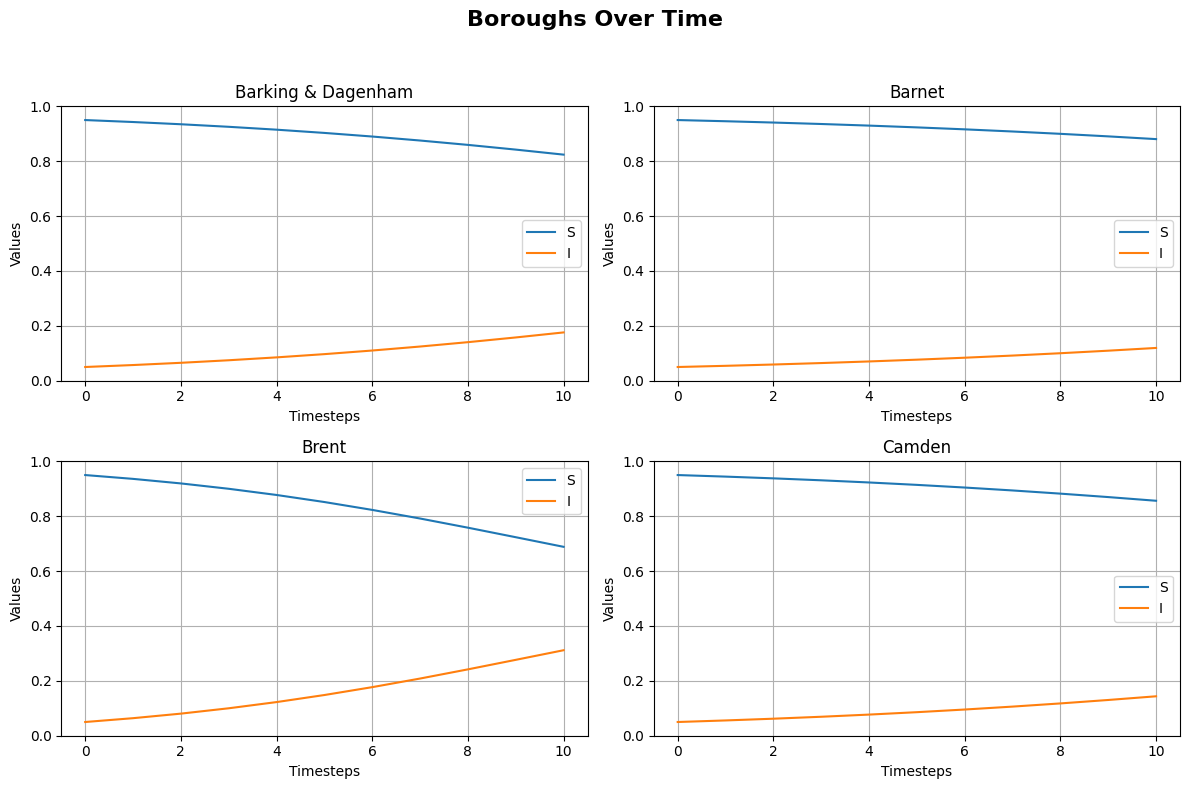

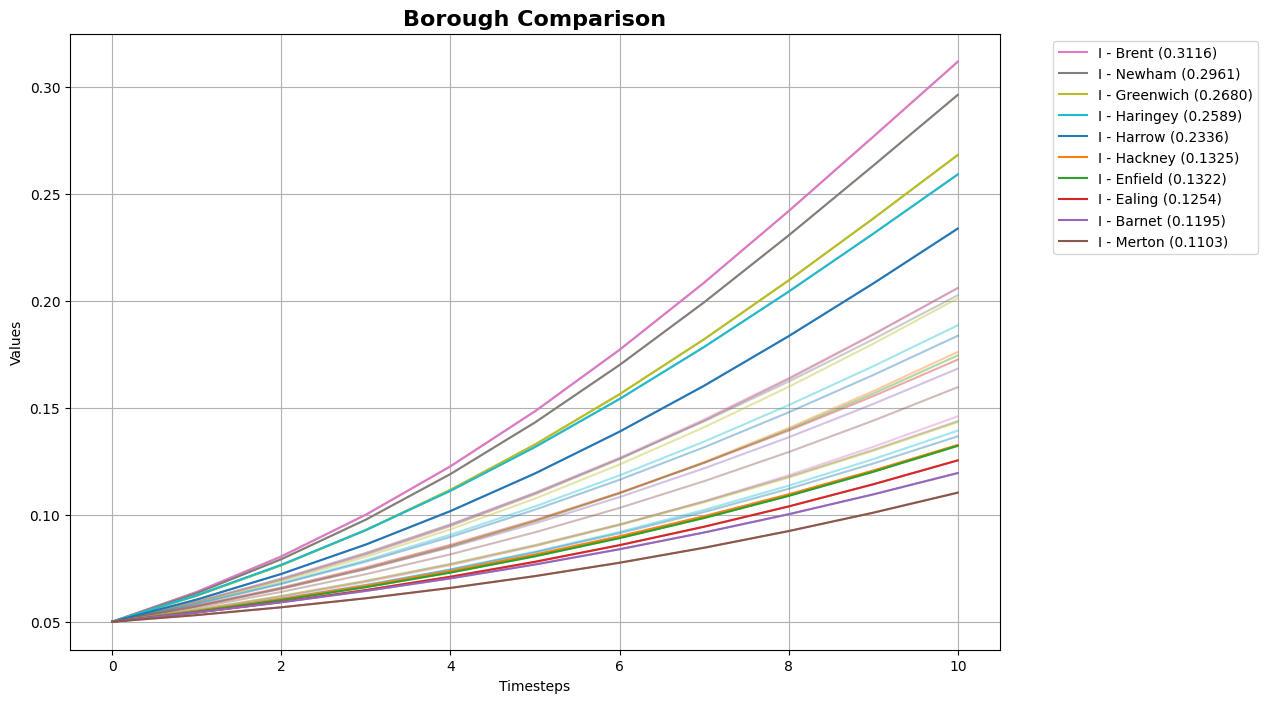

Top 5 highest end states:
Brent: 0.3116
Newham: 0.2961
Greenwich: 0.2680
Haringey: 0.2589
Harrow: 0.2336

Bottom 5 lowest end states:
Hackney: 0.1325
Enfield: 0.1322
Ealing: 0.1254
Barnet: 0.1195
Merton: 0.1103


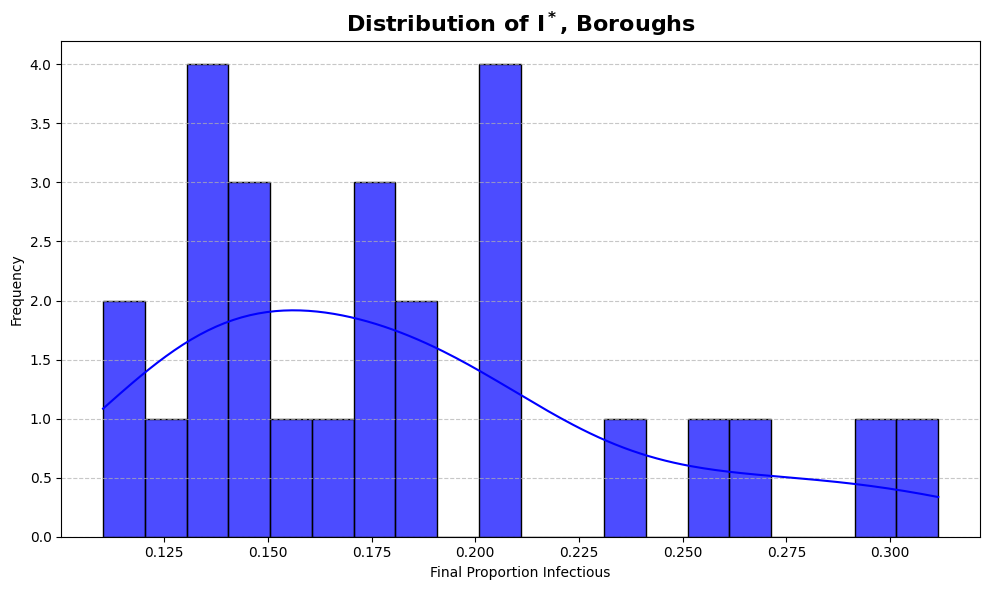

**Mean** $I^*$: 0.1821

**Median** $I^*$: 0.1734

**Standard deviation**: 0.0533

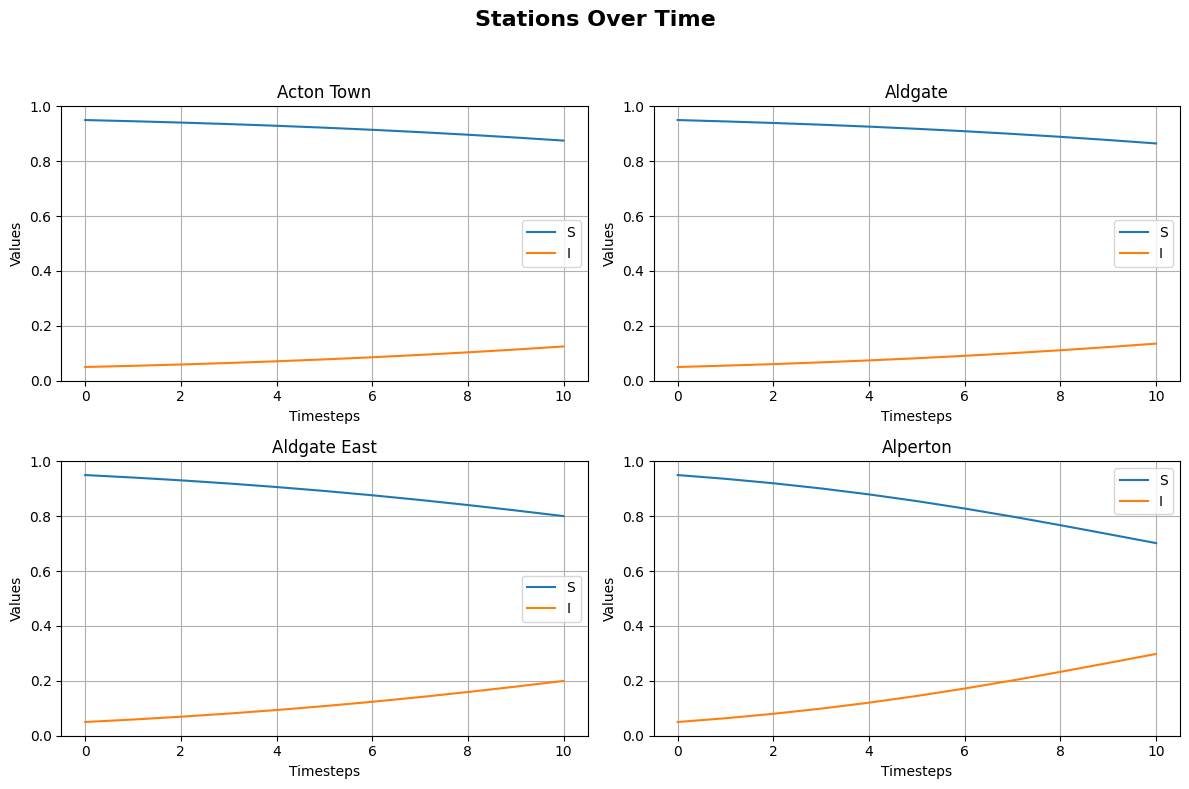

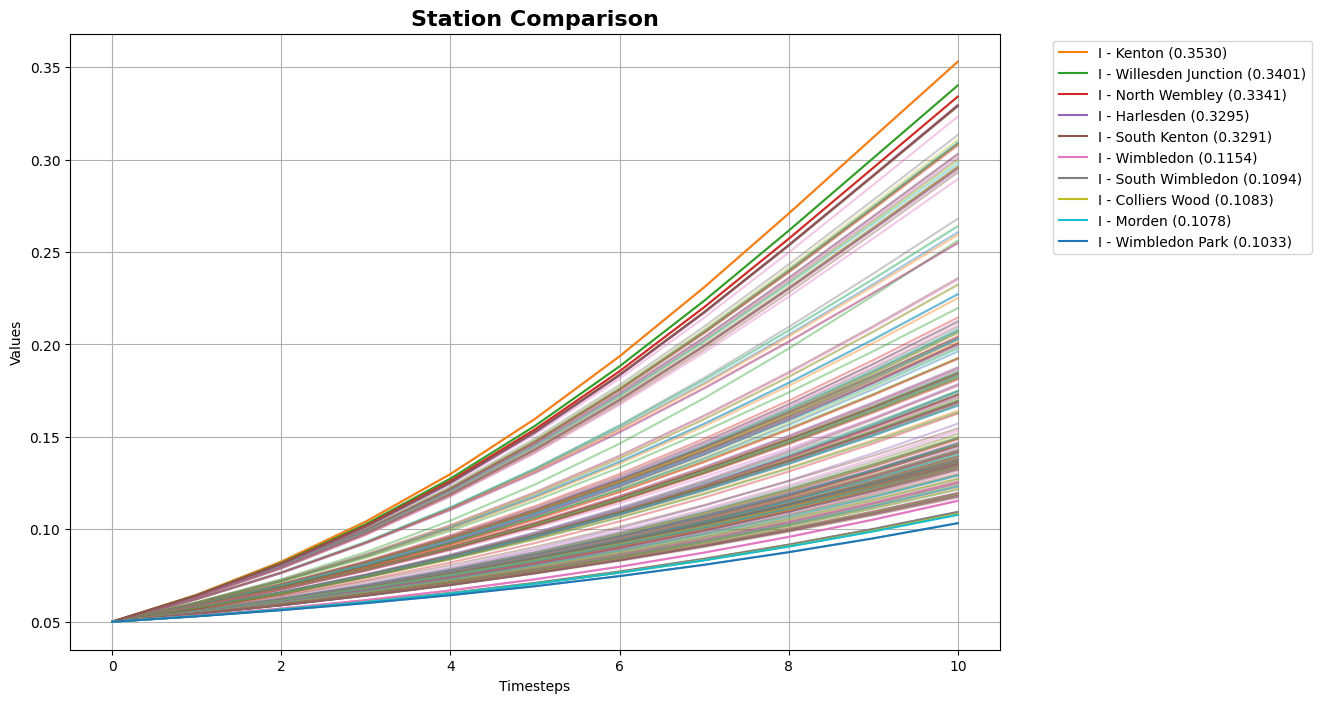

Top 5 highest end states:
Kenton: 0.3530
Willesden Junction: 0.3401
North Wembley: 0.3341
Harlesden: 0.3295
South Kenton: 0.3291

Bottom 5 lowest end states:
Wimbledon: 0.1154
South Wimbledon: 0.1094
Colliers Wood: 0.1083
Morden: 0.1078
Wimbledon Park: 0.1033


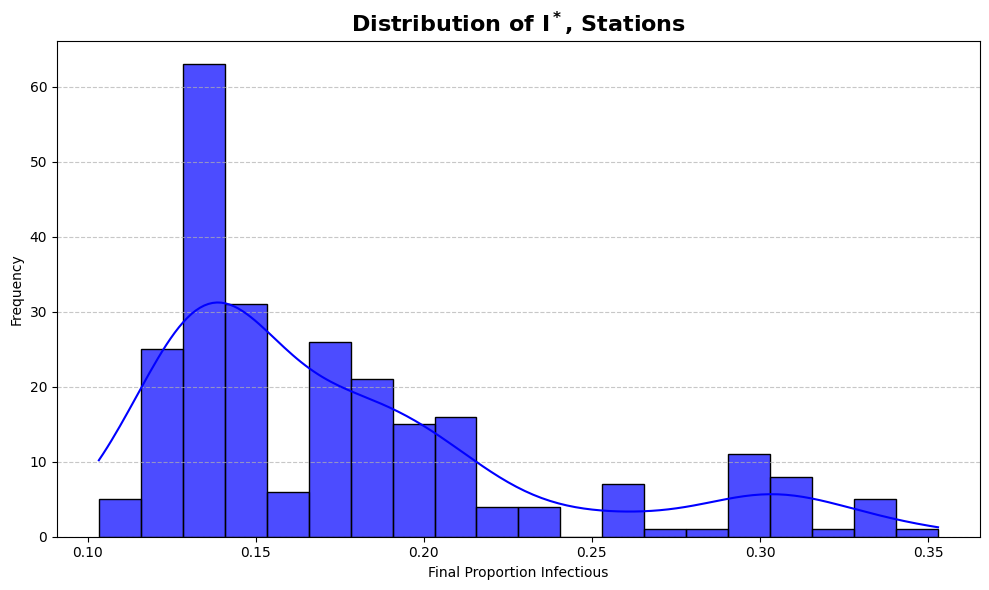

**Mean** $I^*$: 0.1772

**Median** $I^*$: 0.1546

**Standard deviation**: 0.0575

Creating animation: 100%|██████████| 11/11 [00:05<00:00,  2.00it/s]


In [13]:
analyze(solution, params)

In [6]:
# with open('London Example Map Data.pkl', 'wb') as file:
    # pickle.dump(solution, file)

In [52]:
travel_patches

array([   42,    55,   186,   216,   377,   465,   628,   716,   745,
         911,   959,  1120,  1157,  1353,  1470,  1531,  1700,  1831,
        1859,  2030,  2072,  2081,  2090,  2140,  2181,  2205,  2304,
        2468,  2546,  2636,  2637,  2646,  2708,  2724,  2739,  2832,
        2897,  3071,  3232,  3333,  3403,  3570,  3601,  3752,  3916,
        3922,  4068,  4236,  4305,  4355,  4551,  4645,  4895,  4902,
        5150,  5228,  5483,  5496,  5530,  5605,  5653,  5678,  5838,
        5900,  6170,  6178,  6281,  6523,  6555,  6659,  6855,  6871,
        7230,  7305,  7514,  7577,  7592,  7883,  7897,  8070,  8100,
        8143,  8170,  8301,  8317,  8567,  8677,  8928,  9020,  9046,
        9166,  9455,  9487,  9555,  9570,  9889,  9987, 10107, 10163,
       10201, 10372, 10466, 10542, 10758, 10837, 10838, 11087, 11246,
       11304, 11338, 11698, 11827, 11891, 12239, 12258, 12399, 12422,
       12685, 12853, 12867, 13068, 13103, 13442, 13547, 13609, 13786,
       13805, 13859,

In [5]:
subpop_sol, station_sol, borough_sol = solution

In [6]:
station_sol

[array([[15353.19144   , 15172.8633147 , 14976.82008738, ...,
          7507.10268627,  7507.09041334,  7507.07965448],
        [24584.18067   , 24304.5351696 , 24001.9419372 , ...,
         12232.61939487, 12232.59302651, 12232.56987117],
        [37183.30137   , 36772.2348231 , 36327.91030771, ...,
         18676.55321447, 18676.51054554, 18676.47306801],
        ...,
        [33508.97613   , 33119.6571894 , 32698.41789331, ...,
         16525.16739527, 16525.13279537, 16525.10240699],
        [15182.52606   , 14994.1768728 , 14789.45563573, ...,
          7284.85453304,  7284.84202262,  7284.83104182],
        [ 8871.25338   ,  8759.6993319 ,  8638.66905329, ...,
          4240.3932397 ,  4240.38570086,  4240.37908126]]),
 array([[ 1705.91016   ,  1886.2382853 ,  2082.28151262, ...,
          9551.99891373,  9552.01118666,  9552.02194552],
        [ 2731.57563   ,  3011.2211304 ,  3313.8143628 , ...,
         15083.13690513, 15083.16327349, 15083.18642883],
        [ 4131.47793   , 

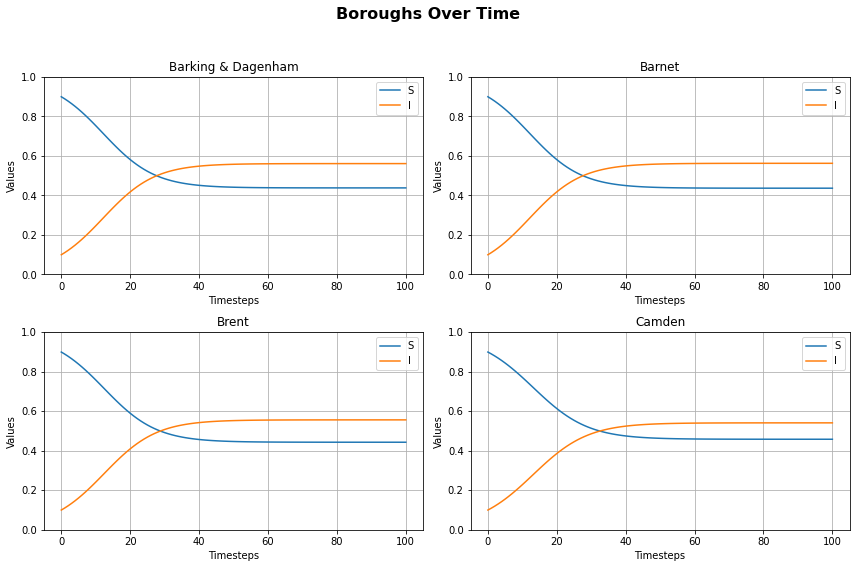

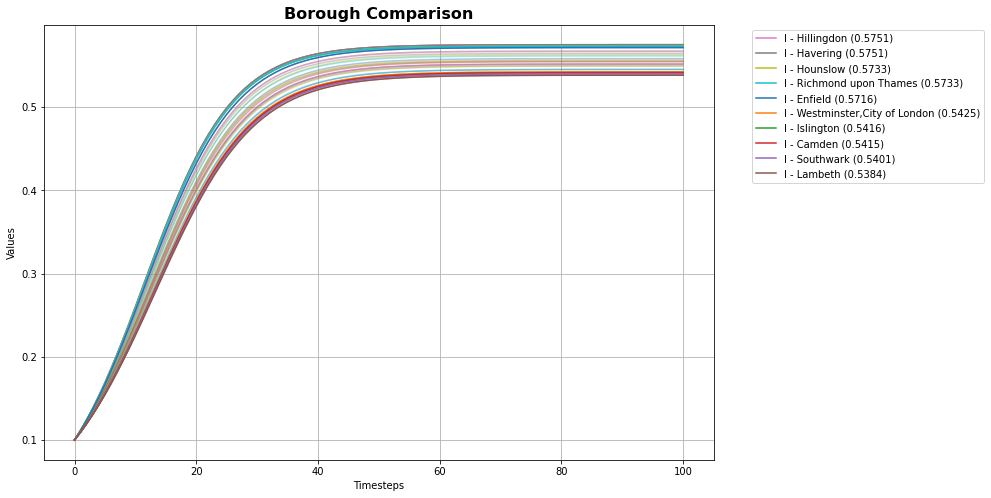

Top 5 highest end states:
Hillingdon: 0.5751
Havering: 0.5751
Hounslow: 0.5733
Richmond upon Thames: 0.5733
Enfield: 0.5716

Bottom 5 lowest end states:
Westminster,City of London: 0.5425
Islington: 0.5416
Camden: 0.5415
Southwark: 0.5401
Lambeth: 0.5384


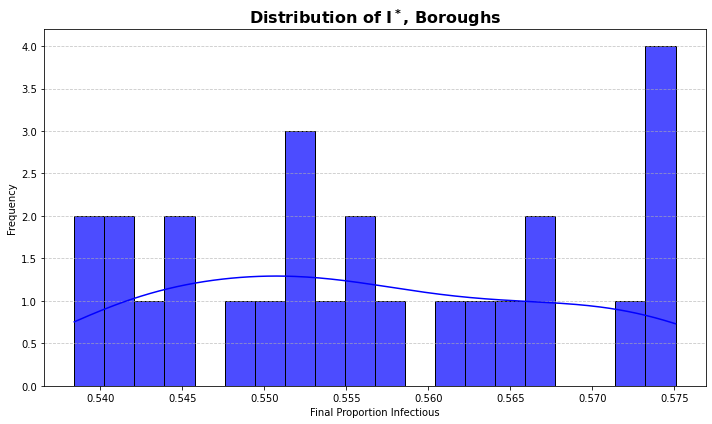

**Mean** $I^*$: 0.5564

**Median** $I^*$: 0.5550

**Standard deviation**: 0.0116

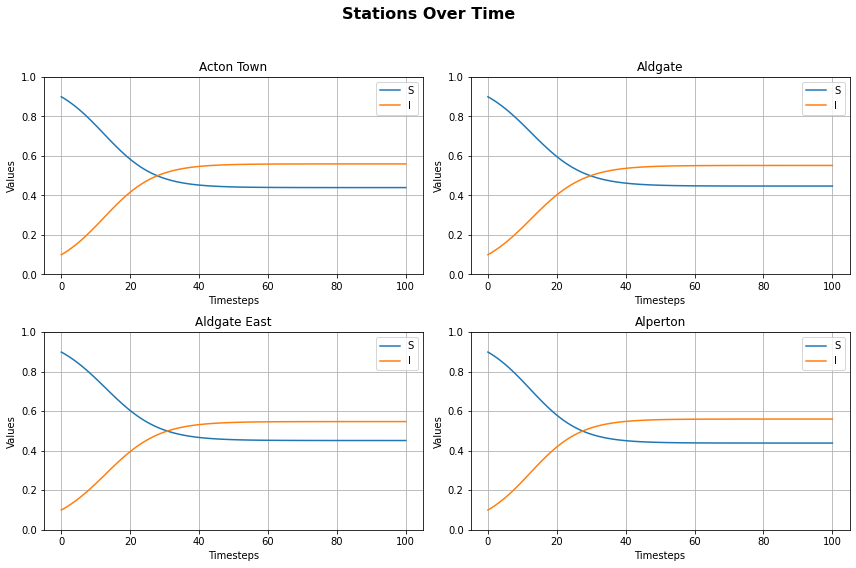

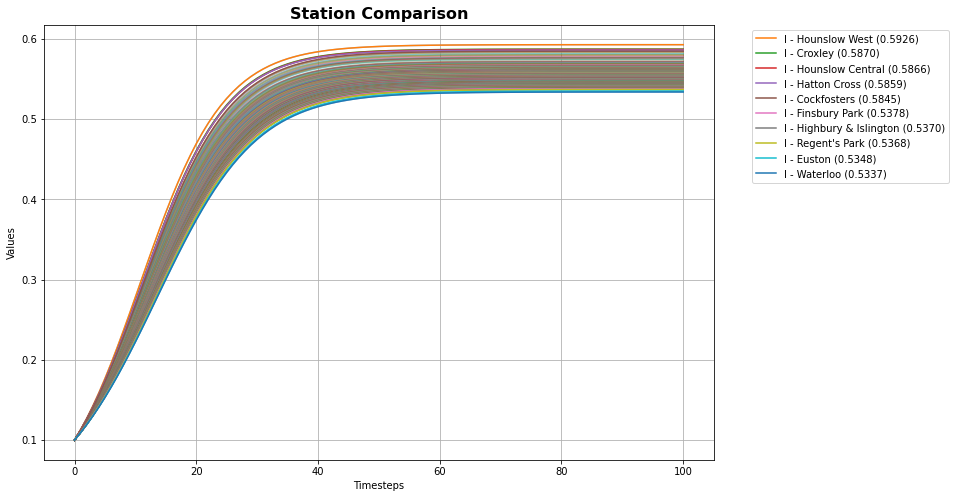

Top 5 highest end states:
Hounslow West: 0.5926
Croxley: 0.5870
Hounslow Central: 0.5866
Hatton Cross: 0.5859
Cockfosters: 0.5845

Bottom 5 lowest end states:
Finsbury Park: 0.5378
Highbury & Islington: 0.5370
Regent's Park: 0.5368
Euston: 0.5348
Waterloo: 0.5337


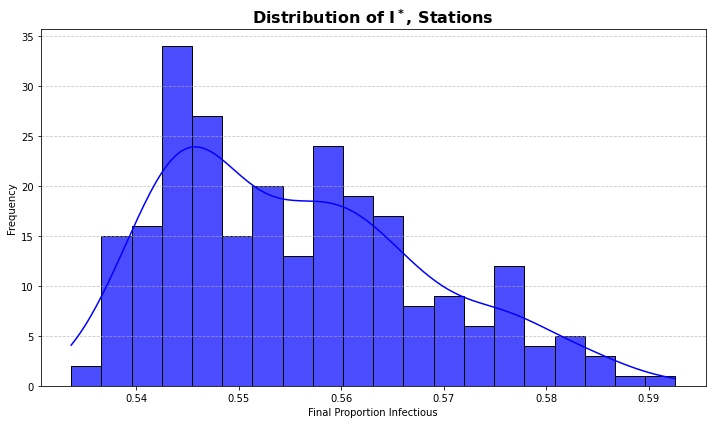

**Mean** $I^*$: 0.5557

**Median** $I^*$: 0.5536

**Standard deviation**: 0.0125

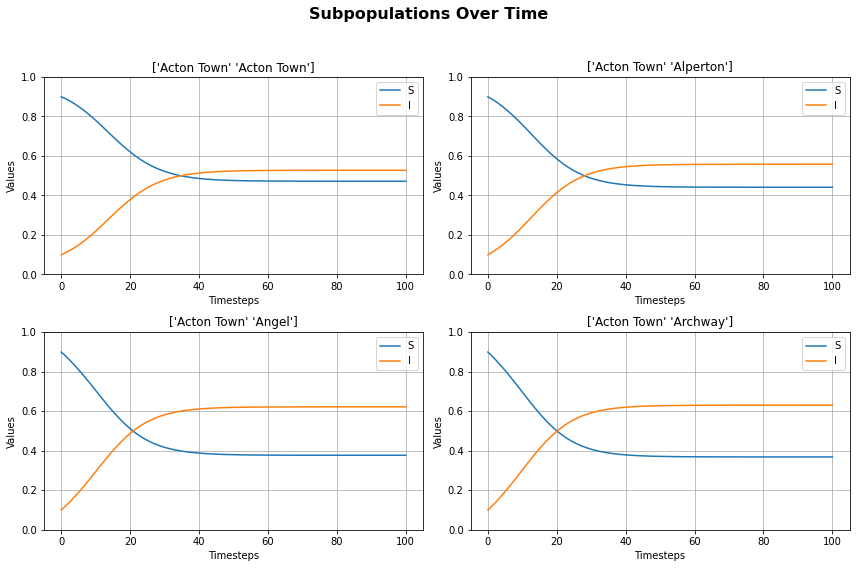

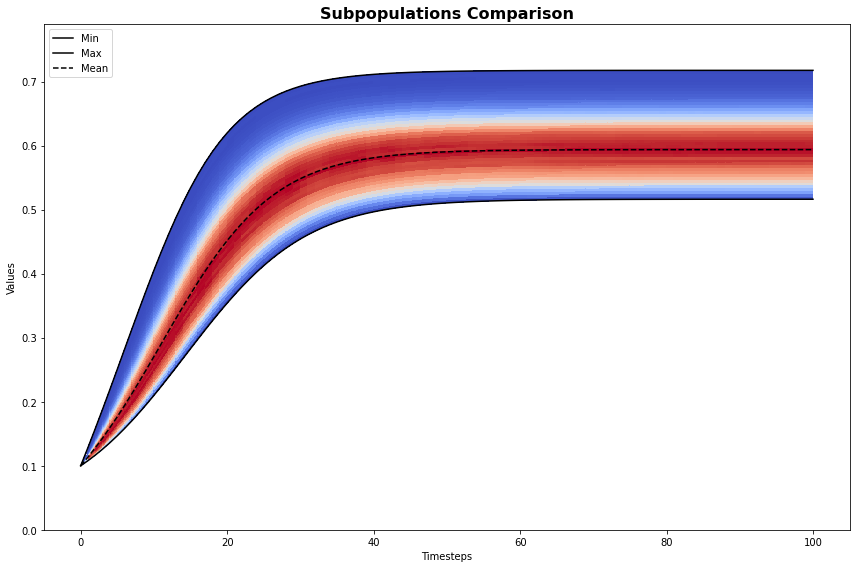

Top 1 highest final values:
['Upminster Bridge' 'Richmond']: 0.7175

Bottom 1 lowest final values:
['Waterloo' 'Waterloo']: 0.5163


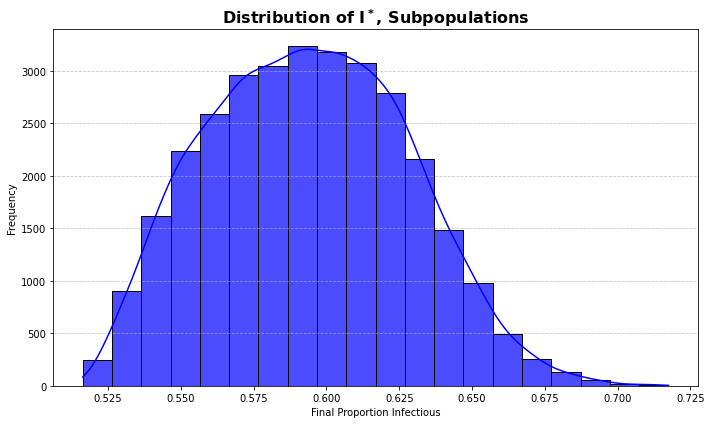

**Mean** $I^*$: 0.5938

**Median** $I^*$: 0.5933

**Standard deviation**: 0.0342

In [7]:
analyze(solution,params)

In [18]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
import requests

# Isolation Tab
def create_isolation_tab(borough_list):
    isolate_label = widgets.HTML(
        "<b>Enable or Disable Borough Isolation:</b> "
        "<p>If enabled, the selected boroughs below will be isolated, "
        "affecting the simulation results. If disabled, the borough selections "
        "will have no effect.</p>"
    )
    isolate_toggle = widgets.ToggleButton(
        value=False, description='Isolate Boroughs?', icon='check',
        layout=widgets.Layout(width='50%')
    )
    starting_borough_checkboxes = [
        widgets.Checkbox(value=False, description=borough, layout=widgets.Layout(width='200px'))
        for borough in borough_list
    ]
    starting_borough_box = widgets.VBox(
        [widgets.Label("Select Starting Boroughs:")] + starting_borough_checkboxes,
        layout=widgets.Layout(overflow='auto', max_height='500px', width='100%')
    )
    starting_borough_box.layout.display = 'none'

    image_widget = widgets.Image(
        value=requests.get("https://i.ebayimg.com/images/g/Rs0AAOSww-hjfP3q/s-l1200.png").content,
        format='png',
        layout=widgets.Layout(width='600px', height='auto', object_fit='contain', display='none')
    )

    def toggle_borough_selection(change):
        if change['new']:
            starting_borough_box.layout.display = 'flex'
            image_widget.layout.display = 'block'
        else:
            starting_borough_box.layout.display = 'none'
            image_widget.layout.display = 'none'
    
    isolate_toggle.observe(toggle_borough_selection, names='value')

    left_content = widgets.VBox([
        isolate_label,
        isolate_toggle,
        starting_borough_box
    ])

    return widgets.HBox([left_content, image_widget]), isolate_toggle, starting_borough_checkboxes


# Main UI
def create_advanced_ui():
    I_prop0_slider = widgets.FloatSlider(
        value=0.1, min=0.0, max=1.0, step=0.05,
        description='I0 Proportion:',
        layout=widgets.Layout(width='80%'),
        style={'description_width': '150px'}
    )
    S_prop0_label = widgets.Label(
        value=f"S0 Proportion: {1.0 - I_prop0_slider.value:.2f}",
        layout=widgets.Layout(margin='0px 0px 0px 68px')
    )

    def update_S_prop0(change):
        S_prop0_label.value = f"S0 Proportion: {1.0 - change['new']:.2f}"
    I_prop0_slider.observe(update_S_prop0, names='value')

    transit_multiplier_slider = widgets.FloatSlider(
        value=10.0, min=0.0, max=20.0, step=0.5,
        description='Transit Multiplier:',
        layout=widgets.Layout(width='80%'),
        style={'description_width': '150px'}
    )

    baseline_beta_slider = widgets.FloatSlider(
        value=0.3, min=0.0, max=1.0, step=0.05,
        description='Baseline β:',
        layout=widgets.Layout(width='80%'),
        style={'description_width': '150px'}
    )

    gamma_slider = widgets.FloatSlider(
        value=1/5, min=0.0, max=1.0, step=0.05,
        description='Recovery Rate γ:',
        layout=widgets.Layout(width='80%'),
        style={'description_width': '150px'}
    )

    timesteps_slider = widgets.IntSlider(
        value=50, min=0, max=100, step=5,
        description='Timesteps:',
        layout=widgets.Layout(width='80%'),
        style={'description_width': '150px'}
    )
    
    isolation_tab, isolate_toggle, starting_borough_checkboxes = create_isolation_tab(borough_list)

    run_button = widgets.Button(description="Run Model", button_style='success', icon='play')
    reset_button = widgets.Button(description="Reset", button_style='danger', icon='refresh')
    output = widgets.Output(
        layout=widgets.Layout(width='100%', height='200px', overflow='auto', border='1px solid black')
    )
    stored_solution = {}
    params = {}

    def reset_ui():
        I_prop0_slider.value = 0.1
        transit_multiplier_slider.value = 10.0
        baseline_beta_slider.value = 0.3
        gamma_slider.value = 1/5
        timesteps_slider.value = 50
        isolate_toggle.value = False
        for checkbox in starting_borough_checkboxes:
            checkbox.value = False
        with output:
            clear_output(wait=True)
            print("Settings reset to defaults.")
    reset_button.on_click(lambda _: reset_ui())

    def run_model():
        with output:
            clear_output(wait=True)
            selected_boroughs = [
                checkbox.description for checkbox in starting_borough_checkboxes if checkbox.value
            ]
            if isolate_toggle.value and not selected_boroughs:
                print("Error: No boroughs selected for isolation.")
                return
            
            S_prop0 = 1.0 - I_prop0_slider.value
            I_prop0 = I_prop0_slider.value
            transit_multiplier = transit_multiplier_slider.value
            baseline_beta = baseline_beta_slider.value
            gamma = gamma_slider.value
            timesteps = timesteps_slider.value
            
            S0 = (np.ones(251) * S_prop0 * completed_commuter_matrix).flatten()
            I0 = (np.ones(251) * I_prop0 * completed_commuter_matrix).flatten()

            if isolate_toggle.value:
                isolate_mask = np.zeros(63001)
                for borough in selected_boroughs:
                    isolate_mask += isolate_borough(borough)
                S0 = S0 / S_prop0
                I0 = I0 * isolate_mask

            # Update params
            params.update({
                'S0': S0,
                'I0': I0,
                'transit_multiplier': transit_multiplier,
                'baseline_beta': baseline_beta,
                'gamma': gamma,
                'timesteps': timesteps,
                'selected_boroughs': selected_boroughs
            })
            print("Running model...")
            solution = run_model_London([S0, I0, transit_multiplier, baseline_beta, gamma, timesteps])
            stored_solution['result'] = solution
            print("Model completed. Results stored.")

    run_button.on_click(lambda _: run_model())

    parameter_tab = widgets.VBox([
        widgets.HTML("<h3>Set Model Parameters</h3>"),
        I_prop0_slider, S_prop0_label, transit_multiplier_slider,
        baseline_beta_slider, gamma_slider, timesteps_slider
    ])
    
    tabs = widgets.Tab(layout=widgets.Layout(width='90%', height='600px'))
    tabs.children = [parameter_tab, isolation_tab]
    tabs.set_title(0, 'Parameters')
    tabs.set_title(1, 'Isolation')

    return widgets.VBox([tabs, widgets.HBox([run_button, reset_button]), output]), stored_solution, params


# Display the UI
ui, stored_solution, params = create_advanced_ui()
display(ui)


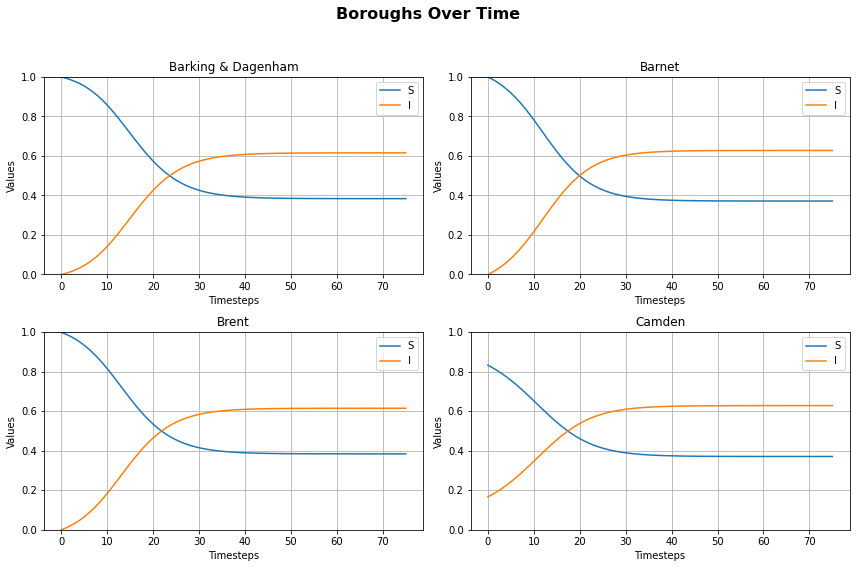

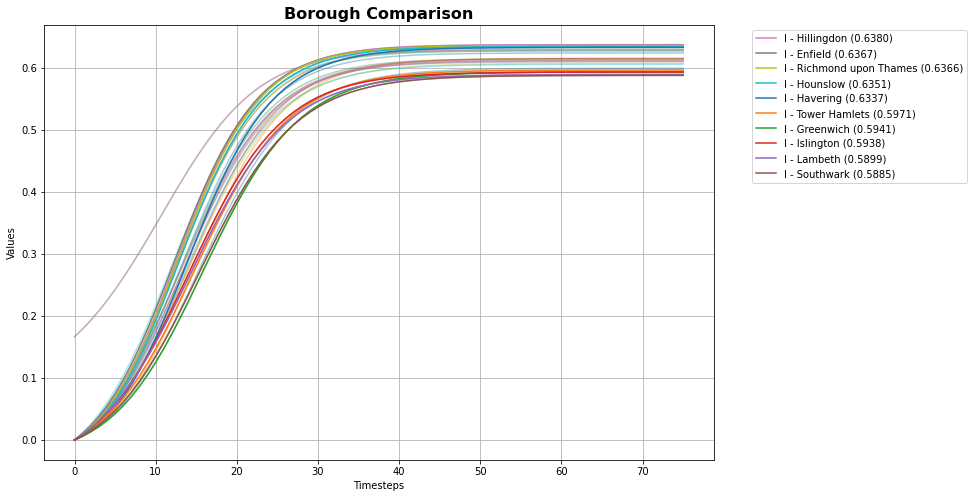

Top 5 highest end states:
Hillingdon: 0.6380
Enfield: 0.6367
Richmond upon Thames: 0.6366
Hounslow: 0.6351
Havering: 0.6337

Bottom 5 lowest end states:
Tower Hamlets: 0.5971
Greenwich: 0.5941
Islington: 0.5938
Lambeth: 0.5899
Southwark: 0.5885


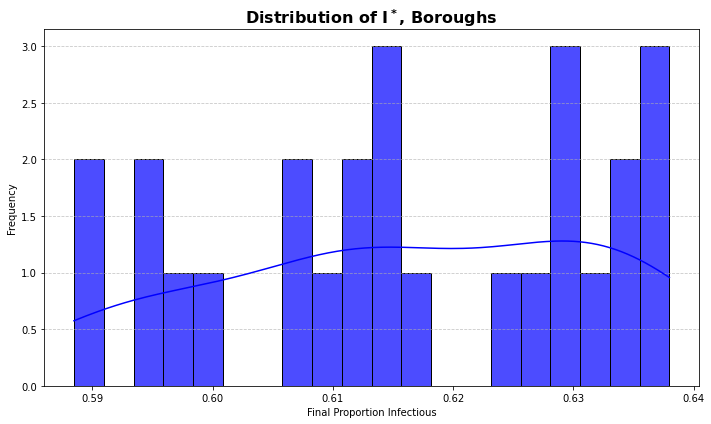

**Mean** $I^*$: 0.6162

**Median** $I^*$: 0.6155

**Standard deviation**: 0.0155

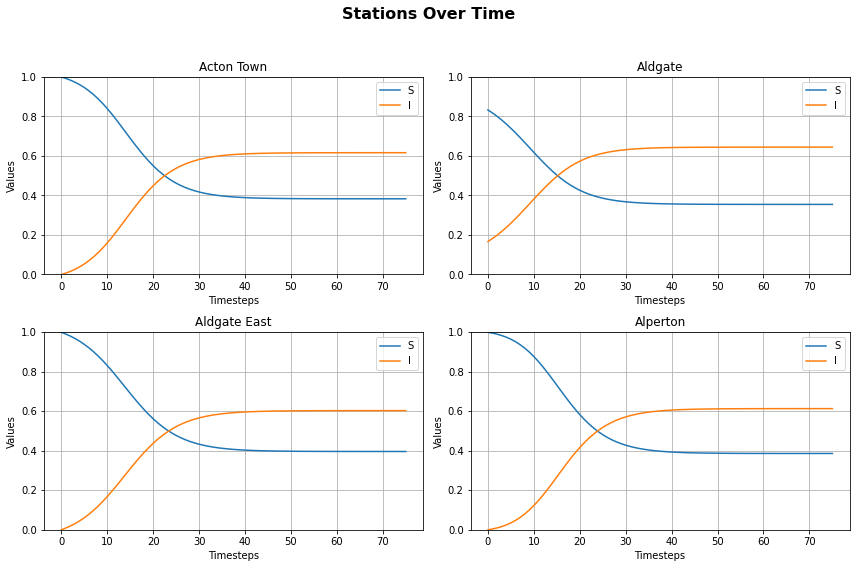

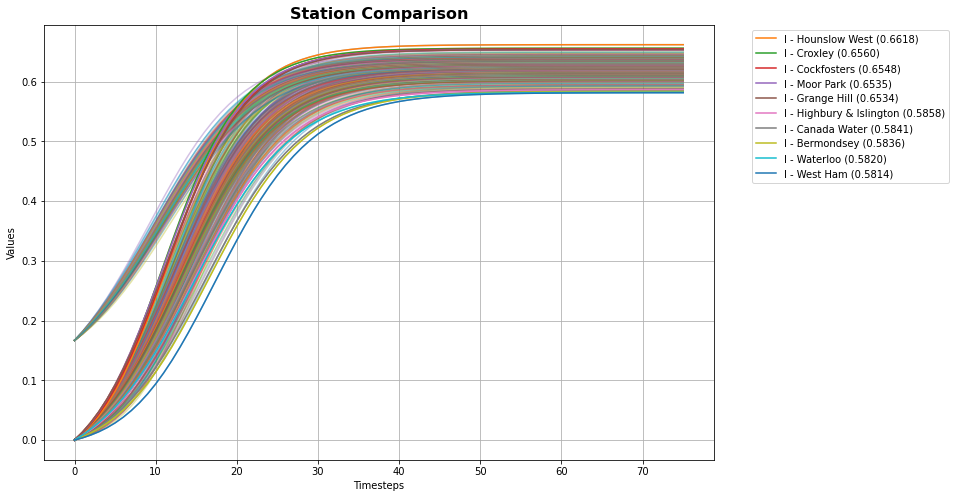

Top 5 highest end states:
Hounslow West: 0.6618
Croxley: 0.6560
Cockfosters: 0.6548
Moor Park: 0.6535
Grange Hill: 0.6534

Bottom 5 lowest end states:
Highbury & Islington: 0.5858
Canada Water: 0.5841
Bermondsey: 0.5836
Waterloo: 0.5820
West Ham: 0.5814


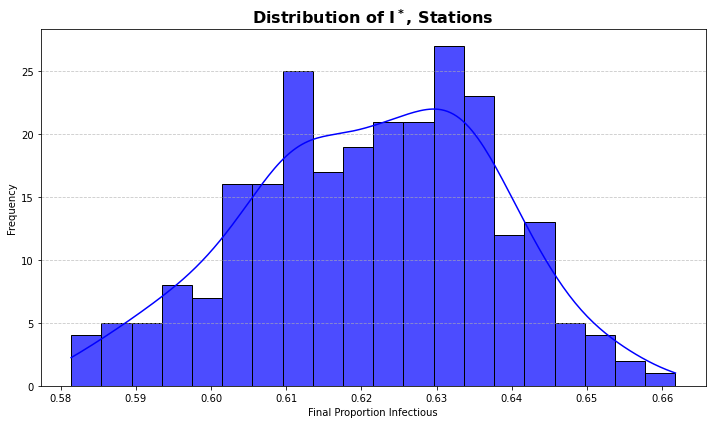

**Mean** $I^*$: 0.6211

**Median** $I^*$: 0.6221

**Standard deviation**: 0.0163

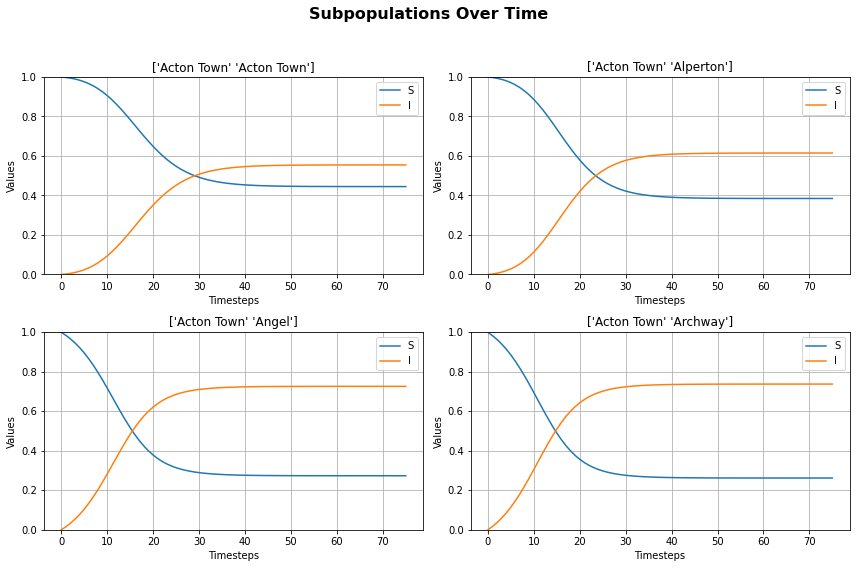

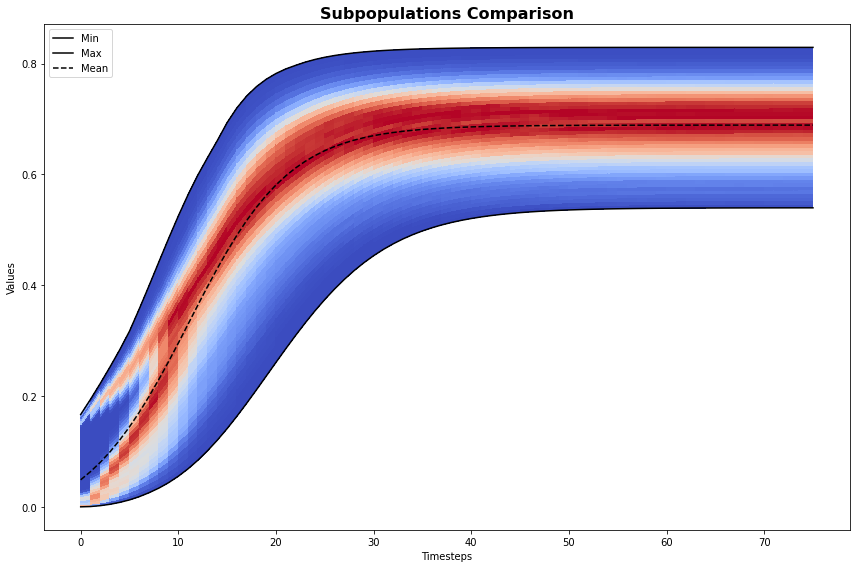

Top 1 highest final values:
['Upminster Bridge' 'Richmond']: 0.8294

Bottom 1 lowest final values:
['West Ham' 'West Ham']: 0.5398


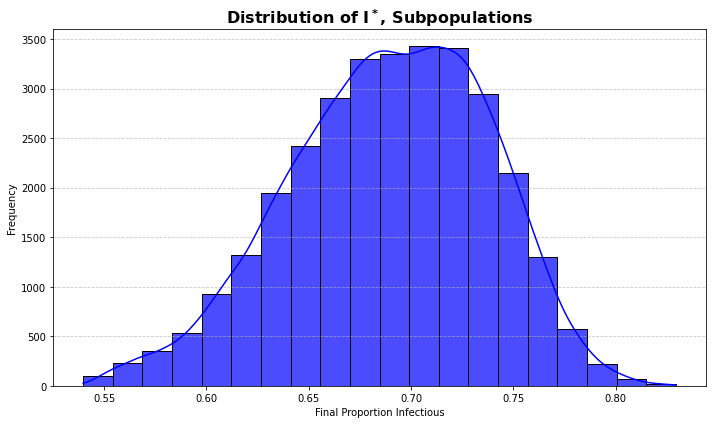

**Mean** $I^*$: 0.6891

**Median** $I^*$: 0.6920

**Standard deviation**: 0.0486

In [19]:
solution = stored_solution['result']
params = list(params.values())[0:-1]

analyze(solution,params)

In [20]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import imageio.v2 as imageio  # Fixes the deprecation warning
import tempfile
import os
from tqdm import tqdm
from matplotlib.colors import Normalize
from PIL import Image, ImageDraw, ImageFont
from IPython.display import HTML

def create_voronoi_gif(solution, params):
    """
    Generates a GIF of the London disease spread simulation using Voronoi coloring while maintaining 
    black station dots and color-changing transit connections.

    Parameters:
    - solution: The output of the disease model simulation.
    - params: Model parameters including timesteps.
    """

    output_filename = "london_voronoi_disease.gif"

    # Load Voronoi shapefile and London boroughs
    voronoi_gdf = gpd.read_file("Fixed_London_Voronoi.shp")  # Voronoi cells
    london_gdf = gpd.read_file("Complete London Shapefile.gpkg", layer="Combined_London_Data")  # Boroughs

    # Extract relevant data from the simulation
    map_data = prepare_solution_for_mapping(solution, params)
    station_data = map_data[1]  # Station-level disease data over time
    travel_data_total = map_data[3]  # Travel infection contributions over time

    num_timesteps = station_data.shape[1]

    # Ensure CRS consistency
    voronoi_gdf = voronoi_gdf.to_crs(london_gdf.crs)

    # Extract station and transit line data
    stations_gdf = london_gdf[london_gdf['type'] == 'station']
    travel_lines_gdf = london_gdf[london_gdf['type'] == 'line']

    # Normalize colormaps for station infection levels and travel connections
    cmap_stations = plt.cm.Reds
    cmap_lines = plt.cm.Oranges  # Different color for travel connections
    norm_stations = Normalize(vmin=0, vmax=np.max(station_data))
    norm_lines = Normalize(vmin=0, vmax=np.max(travel_data_total))

    # **Fix: Match travel data with shapefile lines**
    # Extract station pairs from shapefile
    shapefile_station_pairs = list(zip(travel_lines_gdf['station1'], travel_lines_gdf['station2']))

    # Ensure travel_data_total is correctly ordered by aligning it with station pairs
    travel_data_mapped = []
    for station1, station2 in shapefile_station_pairs:
        try:
            # Find index of the station pair in travel_patch_names
            idx = travel_patch_names.index((station1, station2))
            travel_data_mapped.append(travel_data_total[idx])
        except ValueError:
            # If the station pair is missing, use NaN or 0
            travel_data_mapped.append(np.nan)

    travel_data_mapped = np.array(travel_data_mapped)

    # Create figure
    fig, ax = plt.subplots(figsize=(15, 15))

    with tempfile.TemporaryDirectory() as temp_dir:
        frames = []

        for t in tqdm(range(num_timesteps), desc="Creating Voronoi animation"):
            ax.clear()

            # Plot boroughs as a background layer
            boroughs = london_gdf[london_gdf['type'] == 'borough']
            boroughs.plot(ax=ax, alpha=0.4, color='#ffffff', edgecolor='black', linewidth=0.5, zorder=1)

            # Assign colors to Voronoi regions based on station data
            voronoi_gdf["color"] = [mcolors.to_hex(cmap_stations(norm_stations(val))) for val in station_data[:, t]]
            voronoi_gdf.plot(ax=ax, color=voronoi_gdf["color"], edgecolor="black", linewidth=0.5, alpha=0.7, zorder=2)

            # Assign colors to travel lines based on infection contribution
            travel_lines_gdf.loc[:, "color"] = [
                mcolors.to_hex(cmap_lines(norm_lines(val))) if not np.isnan(val) else "#DDDDDD"
                for val in travel_data_mapped[:, t]
            ]
            travel_lines_gdf.plot(ax=ax, color=travel_lines_gdf["color"], linewidth=2, zorder=3)

            # Plot stations as **black dots**
            stations_gdf.plot(ax=ax, color="black", markersize=30, zorder=4)

            # Save frame
            temp_filepath = os.path.join(temp_dir, f"frame_{t}.png")
            plt.savefig(temp_filepath, bbox_inches='tight')

            # Add title to frame
            titled_frame_path = os.path.join(temp_dir, f"titled_frame_{t}.png")
            add_title_to_image(temp_filepath, f"Disease Levels in London (Time Step t={t})", titled_frame_path)

            frames.append(imageio.imread(titled_frame_path))  # Fix ImageIO warning

        # Create GIF with smooth transition
        imageio.mimsave(output_filename, frames, duration=3.0, loop=0)

    plt.close(fig)

    return HTML(f'<img src="{output_filename}" style="display:block;margin:0 auto;" loop="infinite" autoplay>')


In [23]:
create_voronoi_gif(solution, params)

Creating Voronoi animation:   0%|          | 0/51 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
Creating Voronoi animation: 100%|██████████| 51/51 [00:34<00:00,  1.48it/s]
